# Exploratory Data Analysis Plan for Inner London Rentals
 ## Content 
1. Correlation Matrix of Key Metrics
- 1.1 Top 10 features that have strong correlations
2. Scatter & Regression: Rent vs. Income
3. Rent-to-income vs Crime exposure 
4. Feature Importance Estimate 





In [28]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [29]:
employment_df = pd.read_csv('../data/employment_clean.csv')
crime_df = pd.read_csv('../data/crime_rate_clean.csv')
gcse_df = pd.read_csv("../data/gcse_clean.csv")
listings_df = pd.read_csv("../data/reasonable_listings.csv")

Joining Dataset

Merging datasets on the borough and, when applicable, year_month. Perform left joins starting from listings_df to retain all property records.

In [30]:
# Base: listings
eda_df = listings_df.copy()

# Join crime (two rate columns)
eda_df = eda_df.merge(crime_df[['borough', 'violent_crime1000', 'other_crime1000']], on=['borough'], how='left')
# Join employment (e.g., unemployment_rate)
eda_df = eda_df.merge(employment_df, on=['borough'], how='left')
# Join GCSE if borough-level summary exists
# Assuming gcse_df has borough and year
eda_df = eda_df.merge(gcse_df, on=['borough'], how='left')

print("Final EDA DF shape:", eda_df.shape)



Final EDA DF shape: (2452, 33)


In [31]:
eda_df.head(1)

,id,date_listed,bedrooms,bathrooms,summary,address,property_type,price_amount,price_frequency,latitude,...,is_luxury,affordability,monthly_income,year_month,violent_crime1000,other_crime1000,employment_rate_2024,attainment_8_score,progress_8_score,gcses_passing_rate
0,163439072,2025-06-17,0,0,"Base Rent: £1100, Deposit: £1269.23, Number Of...",Flat 4 27 Seaford Road,Studio,1100.0,Monthly,51.5089,...,False,Borderline,3319.378,2025-06,2.13,6.3725,67.1,47.9,-0.14,0.507


# 1. Correlation Matrix of Key Metrics

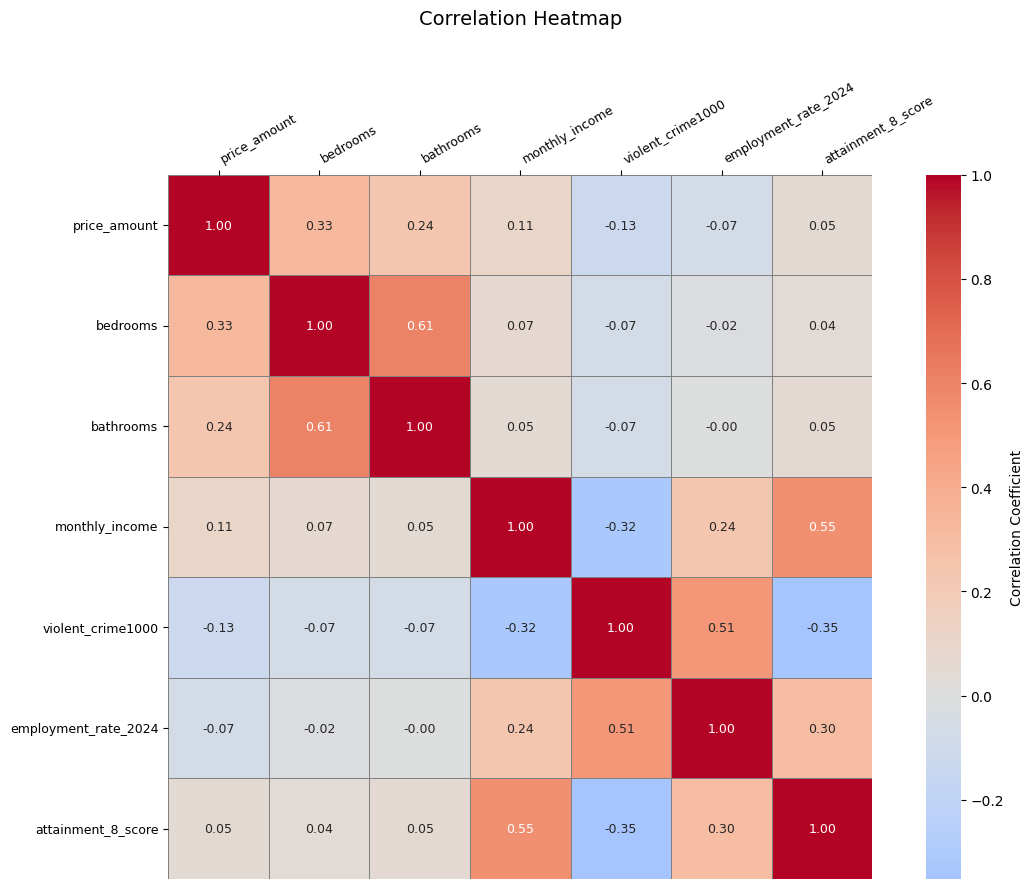

In [32]:
numeric_cols = [
    'price_amount',
    'bedrooms',
    'bathrooms',
    'monthly_income',            # income proxy
    'violent_crime1000',
    'employment_rate_2024',      # 1 metric for labour
    'attainment_8_score'         # 1 metric for education
]

corr_matrix= eda_df[numeric_cols].corr()

plt.figure(figsize=(12, 9))  
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    center=0,
    linewidths=0.5,
    linecolor='grey',
    annot_kws={"size": 9},
    cbar_kws={"label": "Correlation Coefficient"}
)

# Move x-axis labels to top
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Rotate and align labels to prevent blurring
plt.xticks(rotation=30, ha='left', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.title('Correlation Heatmap', fontsize=14, pad=40)
plt.tight_layout()
plt.show()

## 1.1 Top 10 features that have strong correlations

In [33]:
# Flatten the correlation matrix and reset index
corr_pairs = (
    corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))  # remove self-correlations
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Add absolute correlation column
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()

# Sort by absolute correlation (descending)
top_corr = corr_pairs.sort_values(by='abs_corr', ascending=False).drop_duplicates()

# Display top correlations (excluding self-pairs)
top_corr = top_corr[top_corr['abs_corr'] < 1]  # remove perfect correlation duplicates
print(top_corr.head(10))  # Top 10


               Feature 1             Feature 2  Correlation  abs_corr
7               bedrooms             bathrooms     0.607527  0.607527
13             bathrooms              bedrooms     0.607527  0.607527
23        monthly_income    attainment_8_score     0.553906  0.553906
39    attainment_8_score        monthly_income     0.553906  0.553906
28     violent_crime1000  employment_rate_2024     0.511412  0.511412
34  employment_rate_2024     violent_crime1000     0.511412  0.511412
29     violent_crime1000    attainment_8_score    -0.352206  0.352206
40    attainment_8_score     violent_crime1000    -0.352206  0.352206
6               bedrooms          price_amount     0.326419  0.326419
0           price_amount              bedrooms     0.326419  0.326419


In [34]:
print(corr_matrix)

                      price_amount  bedrooms  bathrooms  monthly_income  \
price_amount              1.000000  0.326419   0.239967        0.112349   
bedrooms                  0.326419  1.000000   0.607527        0.069368   
bathrooms                 0.239967  0.607527   1.000000        0.051543   
monthly_income            0.112349  0.069368   0.051543        1.000000   
violent_crime1000        -0.128761 -0.068214  -0.070133       -0.316633   
employment_rate_2024     -0.073239 -0.018422  -0.000597        0.242962   
attainment_8_score        0.053525  0.041535   0.054662        0.553906   

                      violent_crime1000  employment_rate_2024  \
price_amount                  -0.128761             -0.073239   
bedrooms                      -0.068214             -0.018422   
bathrooms                     -0.070133             -0.000597   
monthly_income                -0.316633              0.242962   
violent_crime1000              1.000000              0.511412   
employmen


### Key Insights from Correlation Analysis

- **Price** moderately correlates with **number of bedrooms** and **bathrooms**, indicating larger properties tend to cost more.
- **Monthly income** shows a positive association with educational attainment scores but a weak correlation with price.
- **Violent crime rates** have a slight negative correlation with price and educational attainment, suggesting higher crime areas may see lower rents and poorer education outcomes.
- **Employment rate** correlates positively with lower violent crime and higher educational attainment, highlighting socioeconomic links.
  
Overall, the data suggests that property prices are influenced more by physical features and income than by crime rates directly.


# 2. Scatter & Regression: Rent vs. Income

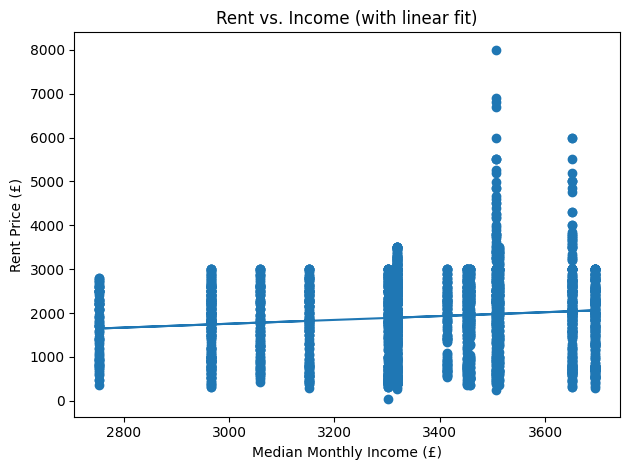

Rent ≈ 0.44×Income + 441.81


In [ ]:
#scatter + line
x= eda_df['monthly_income']
y= eda_df['price_amount']
m,b = np.polyfit(x,y,1)

plt.figure()
plt.scatter(x,y)
plt.plot(x,m* x + b)
plt.xlabel("Median Monthly Income (£)")
plt.ylabel("Rent Price (£)")
plt.title("Rent vs. Income (with linear fit)")
plt.tight_layout()
plt.show()

print(f"Rent ≈ {m:.2f}×Income + {b:.2f}")

Scatter plot Interpretation:For every £1 increase in income, rent increases by approximately £0.44. However, this represents a weak correlation, indicating that income alone is a poor predictor of rent prices in our dataset.

# 3. Rent-to-income vs Crime exposure 

Testing whether higher crime rates correlate with less affordable rents 

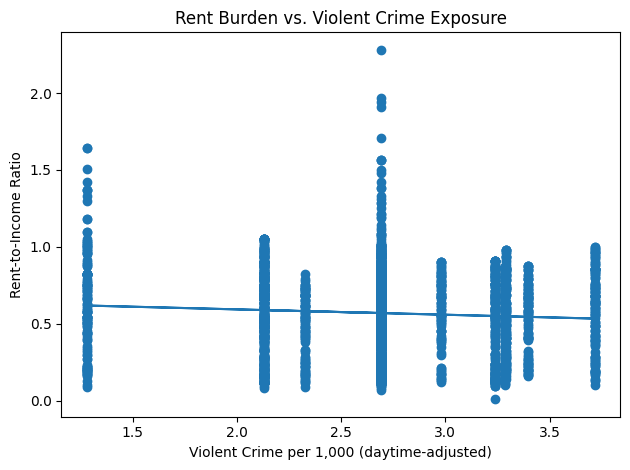

Rent-to-Income ≈ -0.035×Crime + 0.664


In [63]:



x = eda_df['violent_crime1000']
y = eda_df['rent_to_income']
m,b = np.polyfit(x, y, 1)

plt.figure()
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.xlabel('Violent Crime per 1,000 (daytime-adjusted)')
plt.ylabel('Rent-to-Income Ratio')
plt.title('Rent Burden vs. Violent Crime Exposure')
plt.tight_layout()
plt.show()

print(f"Rent-to-Income ≈ {m:.3f}×Crime + {b:.3f}")

Scatter plot rent to income ratio vs. crime interpretations: This are interesting result that have several explanation for the negative correlations between rent to income ratio and crime. 

*  One might be London's rental prices are driven by factors beyond local crime
Things like proximity to work hubs, transport links, amenities, schools, and overall demand impact rent much more directly than crime rates. 
* High crime areas might have lower rents, but also lower incomes. so rent to income ratio could stay similar or even decrease if incomes are propotionally lower 

For further studies i might need to add postcode level stats instead of borough level aggregates. 

In [61]:
eda_df['violent_crime1000'] = eda_df.groupby('borough')['violent_crime1000'].transform(lambda x: x.fillna(x.mean()))
# Step 2: fill remaining NaNs with overall mean (or median)
eda_df['violent_crime1000'] = eda_df['violent_crime1000'].fillna(eda_df['violent_crime1000'].mean())

# 4. Feature Importance Estimate 
- The Random Forest model and feature importance code were adapted from scikit-learn documentation and standard machine learning tutorials.

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Features and target
features = eda_df[[
    'bedrooms', 'bathrooms', 'monthly_income',
    'violent_crime1000', 'other_crime1000',
    'employment_rate_2024', 'attainment_8_score',
    'progress_8_score', 'gcses_passing_rate'
]]
target = eda_df['rent_to_income']  # or rent_to_income

# Fit model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(features, target)

# Feature importances
importances = rf.feature_importances_
for feat, imp in sorted(zip(features.columns, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.3f}")



bedrooms: 0.452
monthly_income: 0.202
bathrooms: 0.156
employment_rate_2024: 0.053
violent_crime1000: 0.034
progress_8_score: 0.034
attainment_8_score: 0.025
other_crime1000: 0.022
gcses_passing_rate: 0.022


Correlation and Random forest model Summary: 
* Rent burden in London is driven mostly by property size(bedrooms, and bathrooms) and income level 
* Social/environmental factors like crime and school performance matters less directly,  but could still play a subtle role in how affordable rents feel in different borough.
* This reinforces that housing affordability is multifaceted, with property characteristics and economic factors leading, while community-level indicators contribute modestly. 
